In [14]:
import pandas as pd
import numpy as np
import os
import sys
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_handler import get_games, compute_head_to_head_avg, get_season_start

df = get_games()

In [ ]:
df['home_avg_points'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_avg_points'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df[['home_head_to_head_avg_points', 'away_head_to_head_avg_points']] = df.apply(
    lambda row: compute_head_to_head_avg(row, df), axis=1
)

df['home_last_5_win_percentage'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_last_5_win_percentage'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['gameDate'] = pd.to_datetime(df['gameDate'], errors='coerce', utc=True)

df['season'] = df['gameDate'].apply(get_season_start)

df = df.sort_values('gameDate').reset_index(drop=True)

df['home_season_win_percentage'] = (
    df.groupby(['home_teamId', 'season'])['home_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['away_season_win_percentage'] = (
    df.groupby(['away_teamId', 'season'])['away_win']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_advantage'] = 1

# Offensive Efficiency (points per possession)
df['home_possessions'] = df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'] + df['home_turnovers']
df['away_possessions'] = df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'] + df['away_turnovers']

df['home_off_efficiency'] = df['home_teamScore'] / df['home_possessions'].replace(0, np.nan)
df['away_off_efficiency'] = df['away_teamScore'] / df['away_possessions'].replace(0, np.nan)

df['home_off_eff_L5'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_off_eff_L5'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_off_eff_L10'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_off_eff_L10'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Defensive Efficiency (points allowed)
df['home_def_efficiency'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_def_efficiency'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Pace (possessions per game)
df['game_pace'] = (df['home_possessions'] + df['away_possessions']) / 2
df['home_pace_L5'] = (
    df.groupby('home_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pace_L5'] = (
    df.groupby('away_teamId')['game_pace']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pace'] = (
    df['home_fieldGoalsAttempted'] + df['home_turnovers'] + 0.44 * df['home_freeThrowsAttempted']
)
df['away_pace'] = (
    df['away_fieldGoalsAttempted'] + df['away_turnovers'] + 0.44 * df['away_freeThrowsAttempted']
)

df['home_pace_avg'] = (
    df.groupby('home_teamId')['home_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_pace_avg'] = (
    df.groupby('away_teamId')['away_pace']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['pace_sum'] = df['home_pace_avg'] + df['away_pace_avg']

df['home_eFG'] = (df['home_fieldGoalsMade'] + 0.5 * df['home_threePointersMade']) / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_eFG'] = (df['away_fieldGoalsMade'] + 0.5 * df['away_threePointersMade']) / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_eFG_L5'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_eFG_L5'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_eFG_L10'] = (
    df.groupby('home_teamId')['home_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_eFG_L10'] = (
    df.groupby('away_teamId')['away_eFG']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Three-Point Shooting
df['home_3p_made_L5'] = (
    df.groupby('home_teamId')['home_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_3p_made_L5'] = (
    df.groupby('away_teamId')['away_threePointersMade']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_reb_L5'] = (
    df.groupby('home_teamId')['home_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_reb_L5'] = (
    df.groupby('away_teamId')['away_reboundsTotal']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_oreb_rate'] = df['home_reboundsOffensive'] / (df['home_reboundsOffensive'] + df['away_reboundsDefensive']).replace(0, np.nan)
df['away_oreb_rate'] = df['away_reboundsOffensive'] / (df['away_reboundsOffensive'] + df['home_reboundsDefensive']).replace(0, np.nan)

df['home_oreb_rate_L5'] = (
    df.groupby('home_teamId')['home_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_oreb_rate_L5'] = (
    df.groupby('away_teamId')['away_oreb_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_to_L5'] = (
    df.groupby('home_teamId')['home_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_to_L5'] = (
    df.groupby('away_teamId')['away_turnovers']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ast_L5'] = (
    df.groupby('home_teamId')['home_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ast_L5'] = (
    df.groupby('away_teamId')['away_assists']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

# Points in Paint
df['home_paint_L5'] = (
    df.groupby('home_teamId')['home_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_paint_L5'] = (
    df.groupby('away_teamId')['away_pointsInThePaint']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_fastbreak_L5'] = (
    df.groupby('home_teamId')['home_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_fastbreak_L5'] = (
    df.groupby('away_teamId')['away_pointsFastBreak']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L3'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)
df['away_pts_L3'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

df['home_pts_L5'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_pts_L5'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_pts_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_pts_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['home_pts_std_L10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)
df['away_pts_std_L10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=3).std())
)

df['home_home_pts_avg'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_away_pts_avg'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_trend_10'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['away_trend_10'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(10, 2).apply(lambda x: x.iloc[-1] - x.iloc[0]))
)

df['home_allowed_avg'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_allowed_avg'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_win_pct_L10'] = (
    df.groupby('home_teamId')['home_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)
df['away_win_pct_L10'] = (
    df.groupby('away_teamId')['away_win']
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

df['expected_total_score'] = df['home_pts_L10'] + df['away_pts_L10']
df['expected_home_vs_away_def'] = df['home_off_eff_L10'] * df['away_def_efficiency']
df['expected_away_vs_home_def'] = df['away_off_eff_L10'] * df['home_def_efficiency']

df['home_off_season'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_off_season'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['home_def_season'] = (
    df.groupby('home_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)
df['away_def_season'] = (
    df.groupby('away_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['expected_total_pre'] = (
    0.5 * (df['home_off_season'] + df['away_off_season']) -
    0.3 * (df['home_def_season'] + df['away_def_season']) +
    0.1 * df['pace_sum']
)

df['pace_differential'] = df['home_pace_L5'] - df['away_pace_L5']

df['off_eff_differential'] = df['home_off_eff_L10'] - df['away_off_eff_L10']
df['def_eff_differential'] = df['home_def_efficiency'] - df['away_def_efficiency']

df['eFG_differential'] = df['home_eFG_L10'] - df['away_eFG_L10']

df['home_momentum'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)
df['away_momentum'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda vals: vals.iloc[-1] - vals.iloc[0] if len(vals) >= 2 else 0
    ))
)

df['home_pts_weighted'] = (
    df.groupby('home_teamId')['home_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_pts_weighted'] = (
    df.groupby('away_teamId')['away_teamScore']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df['home_TS'] = df['home_teamScore'] / (2 * (df['home_fieldGoalsAttempted'] + 0.44 * df['home_freeThrowsAttempted'])).replace(0, np.nan)
df['away_TS'] = df['away_teamScore'] / (2 * (df['away_fieldGoalsAttempted'] + 0.44 * df['away_freeThrowsAttempted'])).replace(0, np.nan)

df['home_TS_L5'] = (
    df.groupby('home_teamId')['home_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_TS_L5'] = (
    df.groupby('away_teamId')['away_TS']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_tov_rate'] = df['home_turnovers'] / df['home_possessions'].replace(0, np.nan)
df['away_tov_rate'] = df['away_turnovers'] / df['away_possessions'].replace(0, np.nan)

df['home_tov_rate_L5'] = (
    df.groupby('home_teamId')['home_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_tov_rate_L5'] = (
    df.groupby('away_teamId')['away_tov_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_ft_rate'] = df['home_freeThrowsAttempted'] / df['home_fieldGoalsAttempted'].replace(0, np.nan)
df['away_ft_rate'] = df['away_freeThrowsAttempted'] / df['away_fieldGoalsAttempted'].replace(0, np.nan)

df['home_ft_rate_L5'] = (
    df.groupby('home_teamId')['home_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)
df['away_ft_rate_L5'] = (
    df.groupby('away_teamId')['away_ft_rate']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df['home_rest_days'] = df.groupby('home_teamId')['gameDate'].diff().dt.days
df['away_rest_days'] = df.groupby('away_teamId')['gameDate'].diff().dt.days
df['home_rest_days'] = df['home_rest_days'].fillna(3).clip(0, 7)  # Cap at 7 days
df['away_rest_days'] = df['away_rest_days'].fillna(3).clip(0, 7)

df['rest_diff'] = df['home_rest_days'] - df['away_rest_days']

df['home_back_to_back'] = (df['home_rest_days'] <= 1).astype(int)
df['away_back_to_back'] = (df['away_rest_days'] <= 1).astype(int)

df['home_off_eff_weighted'] = (
    df.groupby('home_teamId')['home_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)
df['away_off_eff_weighted'] = (
    df.groupby('away_teamId')['away_off_efficiency']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).apply(
        lambda vals: np.average(vals, weights=range(1, len(vals)+1)) if len(vals) > 0 else np.nan
    ))
)

df = df.sort_values("gameDate").reset_index(drop=True)
base_elo = 1500
k = 20

elo = {}

df['home_elo'] = 0.0
df['away_elo'] = 0.0

for i, row in df.iterrows():
    h, a = row['home_teamId'], row['away_teamId']

    # Initialize if unseen
    elo.setdefault(h, base_elo)
    elo.setdefault(a, base_elo)

    # Assign ELO before game
    df.at[i, 'home_elo'] = elo[h]
    df.at[i, 'away_elo'] = elo[a]

    # Calculate expected probabilities
    expected_home = 1 / (1 + 10 ** ((elo[a] - elo[h]) / 400))

    # Actual result
    actual_home = 1 if row['home_win'] == 1 else 0

    # Update ELO
    elo[h] += k * (actual_home - expected_home)
    elo[a] -= k * (actual_home - expected_home)

df['elo_diff'] = df['home_elo'] - df['away_elo']


In [ ]:
features = [
    'home_avg_points', 'away_avg_points',
    'home_head_to_head_avg_points', 'away_head_to_head_avg_points',
    'home_last_5_win_percentage', 'away_last_5_win_percentage',
    'home_advantage'
]
df = df.dropna(subset=features + ['home_teamScore', 'away_teamScore']).reset_index(drop=True)

X = df[features]
y_home = df['home_teamScore']
y_away = df['away_teamScore']

X_train, X_test, yh_train, yh_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, ya_train, ya_test = train_test_split(X, y_away, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

home_model = RandomForestRegressor(n_estimators=200, random_state=42)
away_model = RandomForestRegressor(n_estimators=200, random_state=42)

home_model.fit(X_train_scaled, yh_train)
away_model.fit(X_train_scaled, ya_train)

home_pred = home_model.predict(X_test_scaled)
away_pred = away_model.predict(X_test_scaled)

mae_home = mean_absolute_error(yh_test, home_pred)
mae_away = mean_absolute_error(ya_test, away_pred)
r2_home = r2_score(yh_test, home_pred)
r2_away = r2_score(ya_test, away_pred)

print(f'Home Points - MAE: {mae_home:.2f}, R²: {r2_home:.3f}')
print(f'Away Points - MAE: {mae_away:.2f}, R²: {r2_away:.3f}')

Home Points - MAE: 10.02, R²: 0.018
Away Points - MAE: 10.33, R²: 0.014


In [ ]:
features = [
    # Original features
    'home_avg_points', 'away_avg_points',
    'home_head_to_head_avg_points', 'away_head_to_head_avg_points',
    'home_last_5_win_percentage', 'away_last_5_win_percentage',
    'home_advantage',
    
    # New enhanced features
    'home_off_eff_L5', 'home_off_eff_L10',
    'away_off_eff_L5', 'away_off_eff_L10',
    'home_def_efficiency', 'away_def_efficiency',
    'home_pace_L5', 'away_pace_L5',
    'home_eFG_L5', 'home_eFG_L10',
    'away_eFG_L5', 'away_eFG_L10',
    'home_3p_made_L5', 'away_3p_made_L5',
    'home_reb_L5', 'away_reb_L5',
    'home_oreb_rate_L5', 'away_oreb_rate_L5',
    'home_to_L5', 'away_to_L5',
    'home_ast_L5', 'away_ast_L5',
    'home_paint_L5', 'away_paint_L5',
    'home_fastbreak_L5', 'away_fastbreak_L5',
    'home_pts_L3', 'home_pts_L5', 'home_pts_L10',
    'away_pts_L3', 'away_pts_L5', 'away_pts_L10',
    'home_pts_std_L10', 'away_pts_std_L10',
    'home_win_pct_L10', 'away_win_pct_L10'
]

df = df.dropna(subset=features + ['home_teamScore', 'away_teamScore']).reset_index(drop=True)

X = df[features]
y_home = df['home_teamScore']
y_away = df['away_teamScore']

X_train, X_test, yh_train, yh_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, ya_train, ya_test = train_test_split(X, y_away, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

home_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
away_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

home_model.fit(X_train_scaled, yh_train)
away_model.fit(X_train_scaled, ya_train)

home_pred = home_model.predict(X_test_scaled)
away_pred = away_model.predict(X_test_scaled)

mae_home = mean_absolute_error(yh_test, home_pred)
mae_away = mean_absolute_error(ya_test, away_pred)
r2_home = r2_score(yh_test, home_pred)
r2_away = r2_score(ya_test, away_pred)

print(f'Random Forest Home - MAE: {mae_home:.2f}, R²: {r2_home:.3f}')
print(f'Random Forest Away - MAE: {mae_away:.2f}, R²: {r2_away:.3f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': home_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f'\nAll Features Importance:')
print(feature_importance)

Random Forest Home - MAE: 9.42, R²: 0.169
Random Forest Away - MAE: 9.54, R²: 0.167

All Features Importance:
                 feature  importance
14  expected_total_score    0.218767
13              elo_diff    0.112671
12              away_elo    0.076415
0        home_avg_points    0.067727
2       home_allowed_avg    0.067085
3       away_allowed_avg    0.065806
1        away_avg_points    0.060961
5          away_pace_avg    0.059442
7            home_pts_L3    0.057124
8            away_pts_L3    0.056195
6               pace_sum    0.052600
11              home_elo    0.052567
4          home_pace_avg    0.052254
9         home_rest_days    0.000227
10        away_rest_days    0.000159


Dataset size: 11363 games
Total features: 19

Training HOME models...
Training AWAY models...

HOME TEAM PREDICTIONS:
  Train Set: MAE=8.77, RMSE=11.32, R²=0.211
  Val   Set: MAE=9.59, RMSE=11.94, R²=0.146
  Test  Set: MAE=9.36, RMSE=11.91, R²=0.157
  Train-Test Gap: MAE=0.59, R²=0.055

AWAY TEAM PREDICTIONS:
  Train Set: MAE=8.95, RMSE=11.49, R²=0.215
  Val   Set: MAE=9.45, RMSE=11.91, R²=0.155
  Test  Set: MAE=9.62, RMSE=12.25, R²=0.118
  Train-Test Gap: MAE=0.66, R²=0.097

✓  Model generalization alright

3. CROSS-VALIDATION (5-FOLD)

HOME CV MAE: 9.41 (+/- 0.13)
AWAY CV MAE: 9.50 (+/- 0.08)

Game 1:
  HOME: 109.9 – [116.3] – 121.8   (Actual: 120.0)
  AWAY: 107.8 – [114.5] – 122.1   (Actual: 89.0)

Game 2:
  HOME: 110.5 – [117.5] – 125.6   (Actual: 106.0)
  AWAY: 99.1 – [106.1] – 113.7   (Actual: 108.0)

Game 3:
  HOME: 107.7 – [114.6] – 121.2   (Actual: 117.0)
  AWAY: 105.6 – [115.8] – 123.3   (Actual: 131.0)

Game 4:
  HOME: 106.2 – [115.8] – 122.0   (Actual: 104.0)
  AWAY: 104.0 

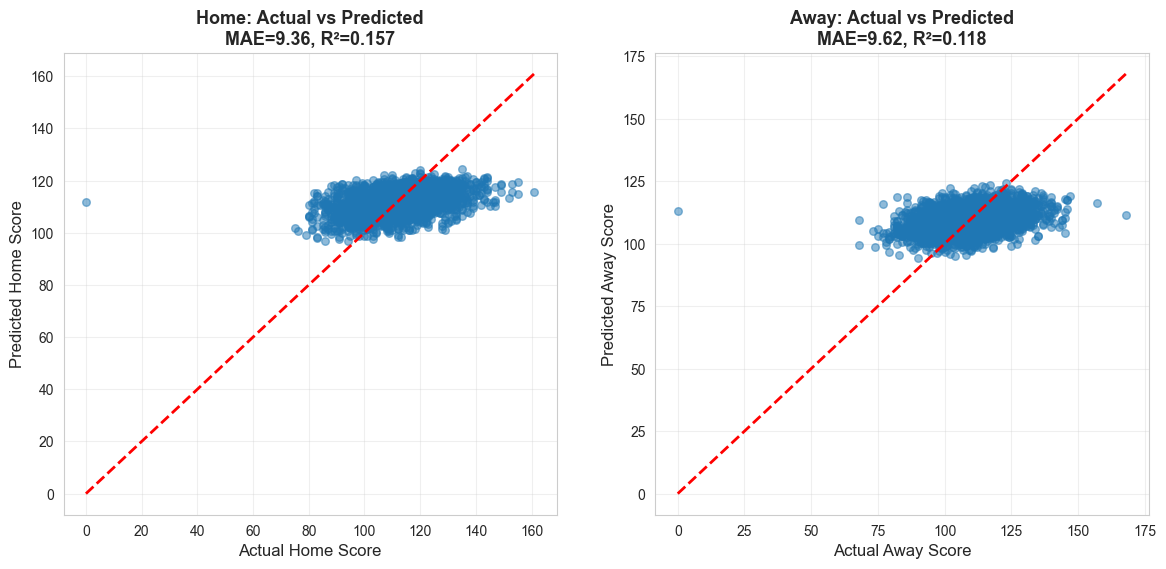


Top correlations with HOME score:
home_teamScore                  1.000000
away_teamScore                  0.347074
home_pts_L3                     0.248291
home_off_eff_L10                0.242737
away_pace_L5                    0.200276
home_TS_L5                      0.200260
home_elo                        0.183705
home_head_to_head_avg_points    0.177496
away_pts_L3                     0.149973
home_pace_L5                    0.144161
pace_sum                        0.117017
away_TS_L5                      0.083728
away_off_eff_L10                0.071266
away_oreb_rate_L5               0.047191
home_oreb_rate_L5               0.039476
Name: home_teamScore, dtype: float64

Top correlations with AWAY score:
away_teamScore                  1.000000
home_teamScore                  0.347074
away_pts_L3                     0.243083
away_off_eff_L10                0.230712
home_pace_L5                    0.217259
away_TS_L5                      0.200456
away_pace_L5                    

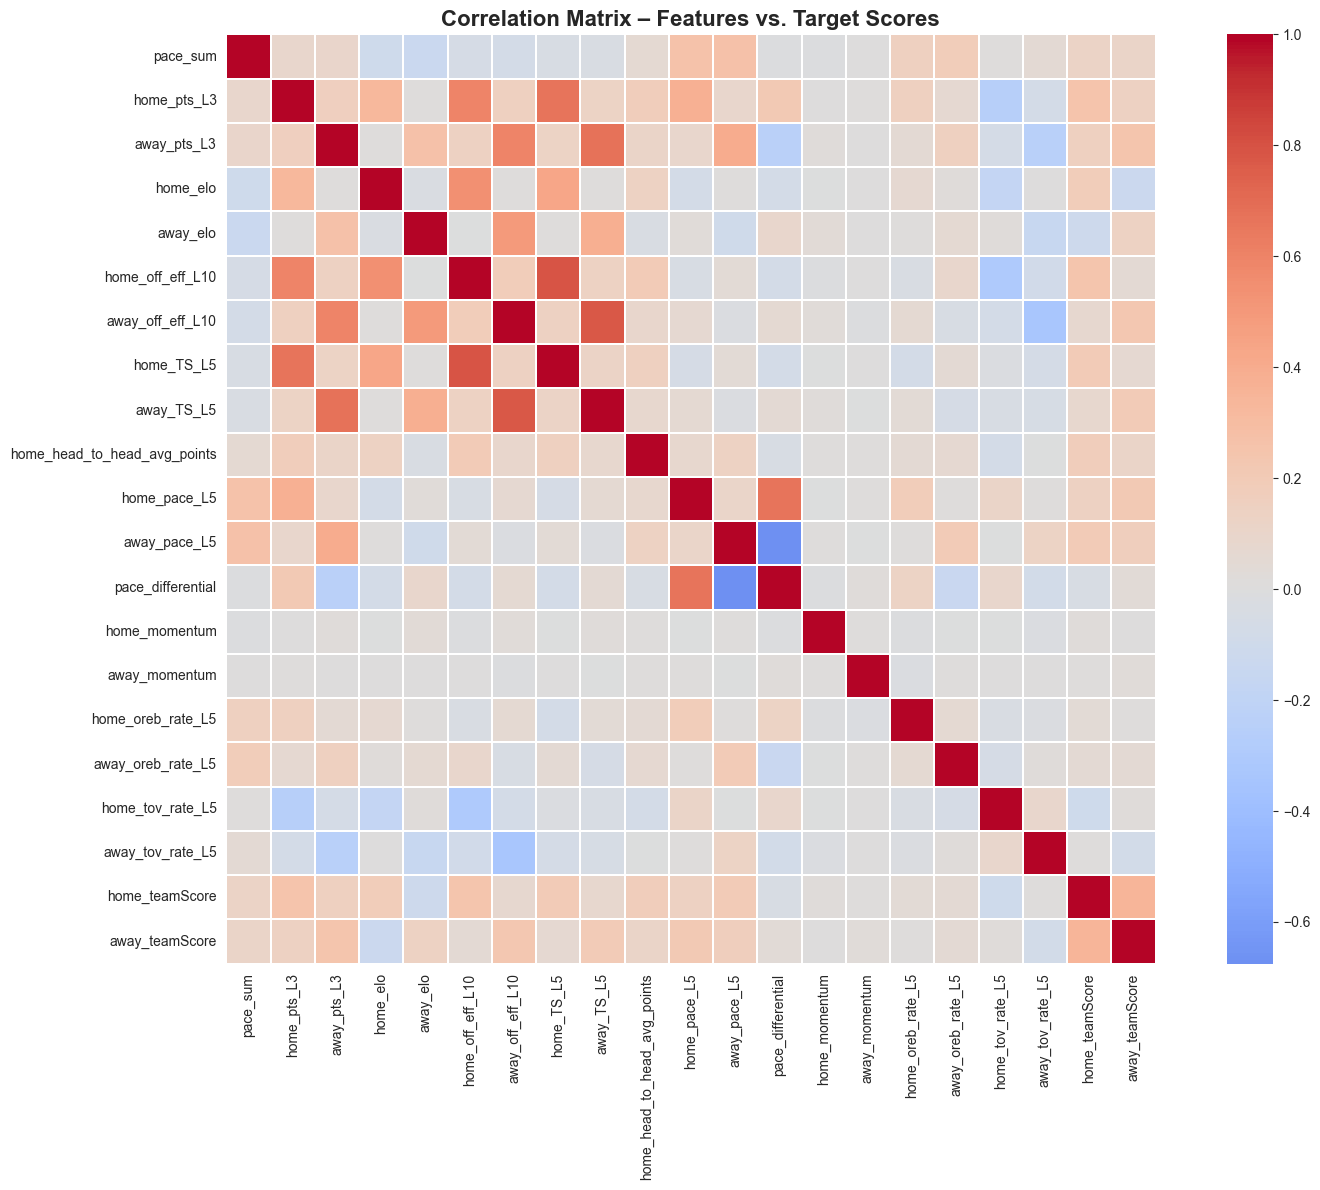

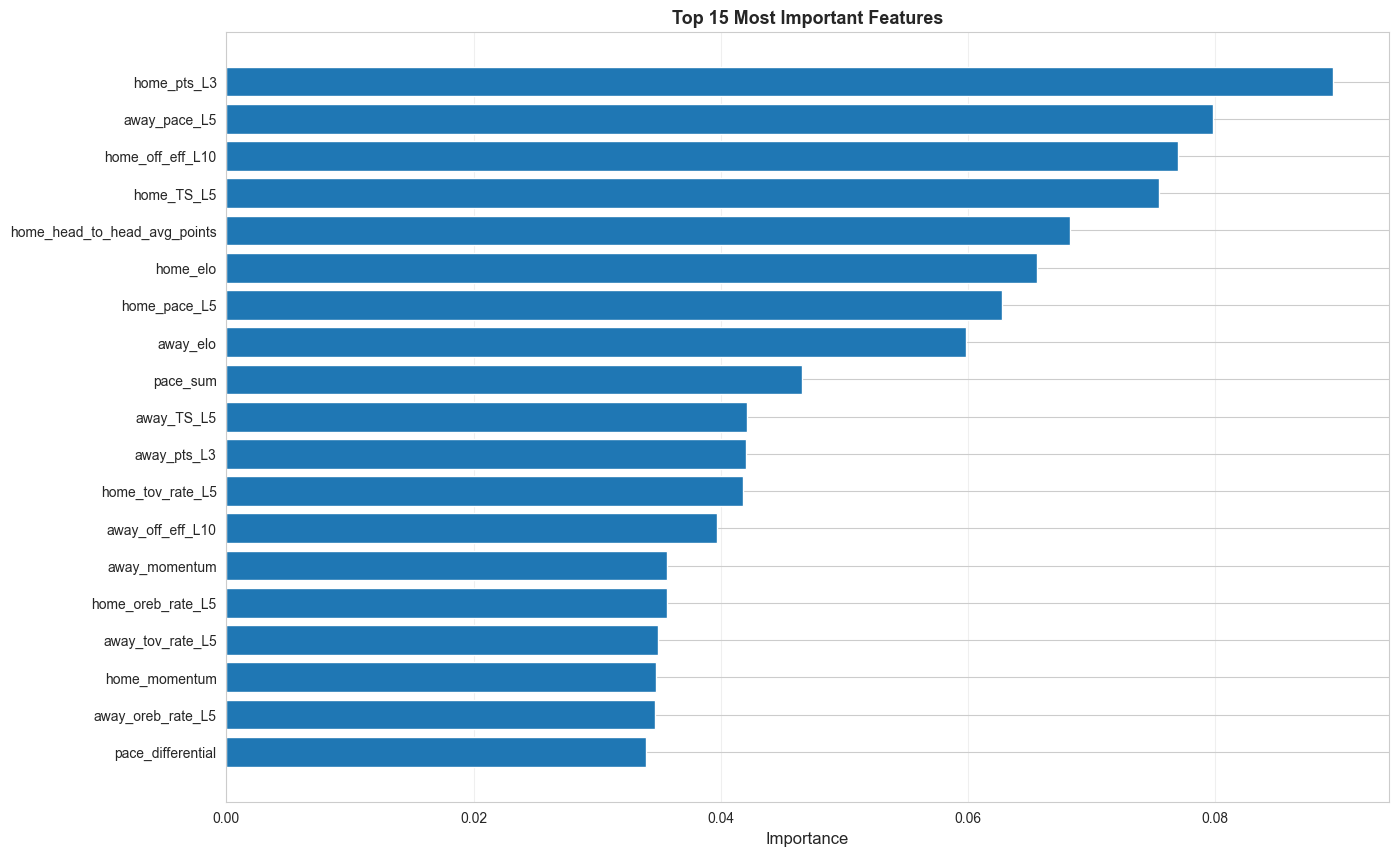

                         feature  importance
1                    home_pts_L3    0.089559
11                  away_pace_L5    0.079809
5               home_off_eff_L10    0.076980
7                     home_TS_L5    0.075424
9   home_head_to_head_avg_points    0.068273
3                       home_elo    0.065540
10                  home_pace_L5    0.062731
4                       away_elo    0.059836
0                       pace_sum    0.046570
8                     away_TS_L5    0.042115
2                    away_pts_L3    0.042037
17              home_tov_rate_L5    0.041783
6               away_off_eff_L10    0.039698
14                 away_momentum    0.035670
15             home_oreb_rate_L5    0.035653
18              away_tov_rate_L5    0.034922
13                 home_momentum    0.034768
16             away_oreb_rate_L5    0.034648
12             pace_differential    0.033985

7. FINAL SUMMARY STATISTICS

HOME TEAM:
  • Test MAE: 9.36 points
  • Test RMSE: 11.91 points
  • T

In [ ]:
features = [
    # 'home_avg_points', 'away_avg_points',
    # 'home_allowed_avg', 'away_allowed_avg',
    # 'home_pace_avg', 'away_pace_avg',
    'pace_sum',
    'home_pts_L3', 'away_pts_L3',
    # 'home_rest_days', 'away_rest_days',
    'home_elo', 'away_elo',
    # 'elo_diff',
    # 'expected_total_score',
    
    'home_off_eff_L10', 'away_off_eff_L10',
    # 'home_def_efficiency', 'away_def_efficiency',
    # 'home_eFG_L10', 'away_eFG_L10',
    'home_TS_L5', 'away_TS_L5',
    # 'home_win_pct_L10', 'away_win_pct_L10',
    'home_head_to_head_avg_points',
    # 'away_head_to_head_avg_points',
    # 'rest_diff', 'home_back_to_back', 'away_back_to_back',
    
    'home_pace_L5', 'away_pace_L5', 'pace_differential',
    'home_momentum',
    'away_momentum',
    'home_oreb_rate_L5', 'away_oreb_rate_L5',
    'home_tov_rate_L5', 'away_tov_rate_L5',
]

df_clean = df.dropna(subset=features + ['home_teamScore', 'away_teamScore']).reset_index(drop=True)
print(f"Dataset size: {len(df_clean)} games")
print(f"Total features: {len(features)}")

X = df_clean[features]
y_home = df_clean['home_teamScore']
y_away = df_clean['away_teamScore']

X_train, X_test, yh_train, yh_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, ya_train, ya_test = train_test_split(X, y_away, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_tr, X_val, yh_tr, yh_val = train_test_split(X_train_scaled, yh_train, test_size=0.2, random_state=42)
_, _, ya_tr, ya_val = train_test_split(X_train_scaled, ya_train, test_size=0.2, random_state=42)

def make_quantile_model(q):
    return xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=3,
        min_child_weight=5,
        subsample=0.7,
        colsample_bytree=0.6,
        gamma=0.1,
        random_state=42,
        n_jobs=-1,
        objective='reg:quantileerror',
        quantile_alpha=q
    )

home_lo_model = make_quantile_model(0.25)
home_md_model = make_quantile_model(0.50)
home_hi_model = make_quantile_model(0.75)

home_lo_model.fit(X_tr, yh_tr, eval_set=[(X_val, yh_val)], verbose=False)
home_md_model.fit(X_tr, yh_tr, eval_set=[(X_val, yh_val)], verbose=False)
home_hi_model.fit(X_tr, yh_tr, eval_set=[(X_val, yh_val)], verbose=False)

away_lo_model = make_quantile_model(0.25)
away_md_model = make_quantile_model(0.50)
away_hi_model = make_quantile_model(0.75)

away_lo_model.fit(X_tr, ya_tr, eval_set=[(X_val, ya_val)], verbose=False)
away_md_model.fit(X_tr, ya_tr, eval_set=[(X_val, ya_val)], verbose=False)
away_hi_model.fit(X_tr, ya_tr, eval_set=[(X_val, ya_val)], verbose=False)

# Predictions on all sets
home_train_pred = home_md_model.predict(X_tr)
home_val_pred = home_md_model.predict(X_val)
home_test_pred = home_md_model.predict(X_test_scaled)

away_train_pred = away_md_model.predict(X_tr)
away_val_pred = away_md_model.predict(X_val)
away_test_pred = away_md_model.predict(X_test_scaled)

# Calculate metrics
def calc_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

home_train_metrics = calc_metrics(yh_tr, home_train_pred)
home_val_metrics = calc_metrics(yh_val, home_val_pred)
home_test_metrics = calc_metrics(yh_test, home_test_pred)

away_train_metrics = calc_metrics(ya_tr, away_train_pred)
away_val_metrics = calc_metrics(ya_val, away_val_pred)
away_test_metrics = calc_metrics(ya_test, away_test_pred)

# Print overfitting analysis
print("\nHOME TEAM PREDICTIONS:")
print(f"  Train Set: MAE={home_train_metrics[0]:.2f}, RMSE={home_train_metrics[1]:.2f}, R²={home_train_metrics[2]:.3f}")
print(f"  Val   Set: MAE={home_val_metrics[0]:.2f}, RMSE={home_val_metrics[1]:.2f}, R²={home_val_metrics[2]:.3f}")
print(f"  Test  Set: MAE={home_test_metrics[0]:.2f}, RMSE={home_test_metrics[1]:.2f}, R²={home_test_metrics[2]:.3f}")
print(f"  Train-Test Gap: MAE={abs(home_train_metrics[0]-home_test_metrics[0]):.2f}, R²={abs(home_train_metrics[2]-home_test_metrics[2]):.3f}")

print("\nAWAY TEAM PREDICTIONS:")
print(f"  Train Set: MAE={away_train_metrics[0]:.2f}, RMSE={away_train_metrics[1]:.2f}, R²={away_train_metrics[2]:.3f}")
print(f"  Val   Set: MAE={away_val_metrics[0]:.2f}, RMSE={away_val_metrics[1]:.2f}, R²={away_val_metrics[2]:.3f}")
print(f"  Test  Set: MAE={away_test_metrics[0]:.2f}, RMSE={away_test_metrics[1]:.2f}, R²={away_test_metrics[2]:.3f}")
print(f"  Train-Test Gap: MAE={abs(away_train_metrics[0]-away_test_metrics[0]):.2f}, R²={abs(away_train_metrics[2]-away_test_metrics[2]):.3f}")

# Overfitting diagnosis
home_overfit = home_train_metrics[2] - home_test_metrics[2]
away_overfit = away_train_metrics[2] - away_test_metrics[2]

if home_overfit > 0.1 or away_overfit > 0.1:
    print("\nWARNING: Possible overfitting detected (R² gap > 0.1)")
else:
    print("\n✓  Model generalization alright")

cv_model_home = make_quantile_model(0.50)
cv_model_away = make_quantile_model(0.50)

cv_scores_home = cross_val_score(cv_model_home, X_train_scaled, yh_train, 
                                  cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_scores_away = cross_val_score(cv_model_away, X_train_scaled, ya_train, 
                                  cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"\nHOME CV MAE: {-cv_scores_home.mean():.2f} (+/- {cv_scores_home.std():.2f})")
print(f"AWAY CV MAE: {-cv_scores_away.mean():.2f} (+/- {cv_scores_away.std():.2f})")

home_min = home_lo_model.predict(X_test_scaled)
home_mid = home_md_model.predict(X_test_scaled)
home_max = home_hi_model.predict(X_test_scaled)

away_min = away_lo_model.predict(X_test_scaled)
away_mid = away_md_model.predict(X_test_scaled)
away_max = away_hi_model.predict(X_test_scaled)

for i in range(5):
    print(f"\nGame {i+1}:")
    print(f"  HOME: {home_min[i]:.1f} – [{home_mid[i]:.1f}] – {home_max[i]:.1f}   (Actual: {yh_test.iloc[i]:.1f})")
    print(f"  AWAY: {away_min[i]:.1f} – [{away_mid[i]:.1f}] – {away_max[i]:.1f}   (Actual: {ya_test.iloc[i]:.1f})")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# --- HOME TEAM ---
plt.subplot(1, 2, 1)
plt.scatter(yh_test, home_mid, alpha=0.5, s=30)
plt.plot(
    [yh_test.min(), yh_test.max()],
    [yh_test.min(), yh_test.max()],
    'r--', lw=2
)
plt.xlabel("Actual Home Score", fontsize=12)
plt.ylabel("Predicted Home Score", fontsize=12)
plt.title(
    f"Home: Actual vs Predicted\nMAE={home_test_metrics[0]:.2f}, R²={home_test_metrics[2]:.3f}",
    fontsize=13,
    fontweight="bold"
)
plt.grid(True, alpha=0.3)

# --- AWAY TEAM ---
plt.subplot(1, 2, 2)
plt.scatter(ya_test, away_mid, alpha=0.5, s=30)
plt.plot(
    [ya_test.min(), ya_test.max()],
    [ya_test.min(), ya_test.max()],
    'r--', lw=2
)
plt.xlabel("Actual Away Score", fontsize=12)
plt.ylabel("Predicted Away Score", fontsize=12)
plt.title(
    f"Away: Actual vs Predicted\nMAE={away_test_metrics[0]:.2f}, R²={away_test_metrics[2]:.3f}",
    fontsize=13,
    fontweight="bold"
)
plt.grid(True, alpha=0.3)
plt.show()

corr_df = df_clean[features + ["home_teamScore", "away_teamScore"]].corr()

print("\nTop correlations with HOME score:")
print(corr_df["home_teamScore"].sort_values(ascending=False).head(15))

print("\nTop correlations with AWAY score:")
print(corr_df["away_teamScore"].sort_values(ascending=False).head(15))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.3
)
plt.title("Correlation Matrix – Features vs. Target Scores", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

importance = home_md_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.show()
print(feature_importance)

print("\n" + "="*60)
print("7. FINAL SUMMARY STATISTICS")
print("="*60)

print(f"\nHOME TEAM:")
print(f"  • Test MAE: {home_test_metrics[0]:.2f} points")
print(f"  • Test RMSE: {home_test_metrics[1]:.2f} points")
print(f"  • Test R²: {home_test_metrics[2]:.3f}")
print(f"  • CV MAE: {-cv_scores_home.mean():.2f} (+/- {cv_scores_home.std():.2f})")

print(f"\nAWAY TEAM:")
print(f"  • Test MAE: {away_test_metrics[0]:.2f} points")
print(f"  • Test RMSE: {away_test_metrics[1]:.2f} points")
print(f"  • Test R²: {away_test_metrics[2]:.3f}")
print(f"  • CV MAE: {-cv_scores_away.mean():.2f} (+/- {cv_scores_away.std():.2f})")

print("\nPREDICTION ACCURACY:")
home_residuals = yh_test - home_mid
within_5 = ((abs(home_residuals) <= 5).sum() / len(home_residuals)) * 100
within_10 = ((abs(home_residuals) <= 10).sum() / len(home_residuals)) * 100
print(f"  • Predictions within 5 points: {within_5:.1f}%")
print(f"  • Predictions within 10 points: {within_10:.1f}%")


In [49]:
features = [
    # Original features
    'home_avg_points', 'away_avg_points',
    'home_head_to_head_avg_points', 'away_head_to_head_avg_points',
    'home_last_5_win_percentage', 'away_last_5_win_percentage',
    
    # Enhanced features from before
    'home_off_eff_L5', 'home_off_eff_L10',
    'away_off_eff_L5', 'away_off_eff_L10',
    'home_def_efficiency', 'away_def_efficiency',
    'home_pace_L5', 'away_pace_L5',
    'home_eFG_L5', 'home_eFG_L10',
    'away_eFG_L5', 'away_eFG_L10',
    'home_3p_made_L5', 'away_3p_made_L5',
    'home_reb_L5', 'away_reb_L5',
    'home_oreb_rate_L5', 'away_oreb_rate_L5',
    'home_to_L5', 'away_to_L5',
    'home_ast_L5', 'away_ast_L5',
    'home_paint_L5', 'away_paint_L5',
    'home_fastbreak_L5', 'away_fastbreak_L5',
    'home_pts_L3', 'home_pts_L5', 'home_pts_L10',
    'away_pts_L3', 'away_pts_L5', 'away_pts_L10',
    'home_pts_std_L10', 'away_pts_std_L10',
    'home_win_pct_L10', 'away_win_pct_L10',
    
    # NEW interaction features
    'expected_total_score',
    'expected_home_vs_away_def',
    'expected_away_vs_home_def',
    'pace_differential',
    'off_eff_differential',
    'def_eff_differential',
    'eFG_differential',
    
    # NEW momentum features
    'home_momentum', 'away_momentum',
    'home_pts_weighted', 'away_pts_weighted',
    
    # NEW Four Factors
    'home_TS_L5', 'away_TS_L5',
    'home_tov_rate_L5', 'away_tov_rate_L5',
    'home_ft_rate_L5', 'away_ft_rate_L5',
    
    # NEW situational features
    'home_rest_days', 'away_rest_days',
    'home_back_to_back', 'away_back_to_back',
    
    # NEW weighted efficiency
    'home_off_eff_weighted', 'away_off_eff_weighted'
]

df = df.dropna(subset=features + ['home_teamScore', 'away_teamScore']).reset_index(drop=True)

X = df[features]
y_home = df['home_teamScore']
y_away = df['away_teamScore']

X_train, X_test, yh_train, yh_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, ya_train, ya_test = train_test_split(X, y_away, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

home_gb = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
away_gb = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)

home_gb.fit(X_train_scaled, yh_train)
away_gb.fit(X_train_scaled, ya_train)

home_pred_gb = home_gb.predict(X_test_scaled)
away_pred_gb = away_gb.predict(X_test_scaled)

print(f'GradBoost - Home: MAE={mean_absolute_error(yh_test, home_pred_gb):.2f}, R²={r2_score(yh_test, home_pred_gb):.3f}')
print(f'GradBoost - Away: MAE={mean_absolute_error(ya_test, away_pred_gb):.2f}, R²={r2_score(ya_test, away_pred_gb):.3f}')

GradBoost - Home: MAE=10.32, R²=-0.051
GradBoost - Away: MAE=9.86, R²=-0.018


In [ ]:
base_dir = os.path.dirname(os.getcwd())
models_dir = os.path.join(base_dir, 'models')
scalers_dir = os.path.join(base_dir, 'scalers')

HOME_MODEL_PATH = os.path.join(models_dir, 'home_points_model.pkl')
AWAY_MODEL_PATH = os.path.join(models_dir, 'away_points_model.pkl')
SCALER_PATH = os.path.join(scalers_dir, 'points_scaler.pkl')

joblib.dump(home_model, HOME_MODEL_PATH)
joblib.dump(away_model, AWAY_MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)


['/Users/simonsalaj/Documents/test_ai/StatistIQApp/Scripts/ai/models/points_scaler.pkl']